In [7]:
iter = 0

## Imports

In [53]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.datasets import fashion_mnist, cifar10, cifar100, mnist
from keras.models import *
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# for quantization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

# for distillation (necesitamos una clase personalizada llamada distillationClassKeras)
from distillationClassKeras import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Dataset

In [2]:
# Carga del dataset, dividido en trainig y testing (data y clase)
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

# One-hot encoding
n_classes = 10
y_train = to_categorical(y_train, num_classes = n_classes)
y_test = to_categorical(y_test, num_classes = n_classes)

## FC NN definition for prunning

#### WARNING
when using keras from raw imports, model is of class `Sequential` instead of `keras.models.Sequential` and that makes `prune_low_magnitude` throw a Class error. Fixed by removing all raw keras imports and using `tensorflow.keras.models.Sequentials` manually...

In [36]:
# MLP architecture
w = 28
h = 28
n_classes = 10

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(w, h)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

# training params
lr = 0.01
op = tf.keras.optimizers.SGD(lr)

model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

model.summary()

# training stage
history = model.fit(x_train_norm, y_train, epochs= 16, batch_size = 50, validation_split=0.2)

# evaluation stage
test_loss, test_acc = model.evaluate(x_test_norm, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 20)                15700     
                                                                 
 dense_9 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
Epoch 1/16
960/960 [==============================] - 5s 4ms/step - loss: 1.0567 - accuracy: 0.7065 - val_loss: 0.5152 - val_accuracy: 0.8724
Epoch 2/16
960/960 [==============================] - 2s 2ms/step - loss: 0.4658 - accuracy: 0.8771 - val_loss: 0.3816 - val_accuracy: 0.8977
Epoch 3/16
960/960 [==========

## Prunning

In [44]:
epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = tf.keras.optimizers.Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2

final_sparsity = 0.9

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=3000
                )
            }

# create prunned model
modelP = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# compile prunned model
modelP.compile(optimizer=op, loss=loss, metrics=metrics)

In [45]:
iter += 1

# fit new prunned model
historyP = modelP.fit(
                x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
            )

Epoch 1/16
750/750 [==============================] - 4s 3ms/step - loss: 0.0874 - accuracy: 0.9741 - val_loss: 0.1592 - val_accuracy: 0.9553
Epoch 2/16
750/750 [==============================] - 2s 3ms/step - loss: 0.3060 - accuracy: 0.9051 - val_loss: 0.8549 - val_accuracy: 0.7148
Epoch 3/16
750/750 [==============================] - 2s 3ms/step - loss: 0.8055 - accuracy: 0.7455 - val_loss: 1.0625 - val_accuracy: 0.6571
Epoch 4/16
750/750 [==============================] - 3s 3ms/step - loss: 0.9452 - accuracy: 0.6783 - val_loss: 0.8459 - val_accuracy: 0.7352
Epoch 5/16
750/750 [==============================] - 2s 2ms/step - loss: 0.8229 - accuracy: 0.7455 - val_loss: 0.7775 - val_accuracy: 0.7610
Epoch 6/16
750/750 [==============================] - 2s 3ms/step - loss: 0.7721 - accuracy: 0.7587 - val_loss: 0.7420 - val_accuracy: 0.7685
Epoch 7/16
750/750 [==============================] - 2s 3ms/step - loss: 0.7428 - accuracy: 0.7657 - val_loss: 0.7189 - val_accuracy: 0.7738
Epoch 

In [46]:
modelP.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatten  (None, 784)              1         
 _7 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_8  (None, 20)               31382     
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_9  (None, 10)               412       
  (PruneLowMagnitude)                                            
                                                                 
Total params: 31,795
Trainable params: 15,910
Non-trainable params: 15,885
_________________________________________________________________


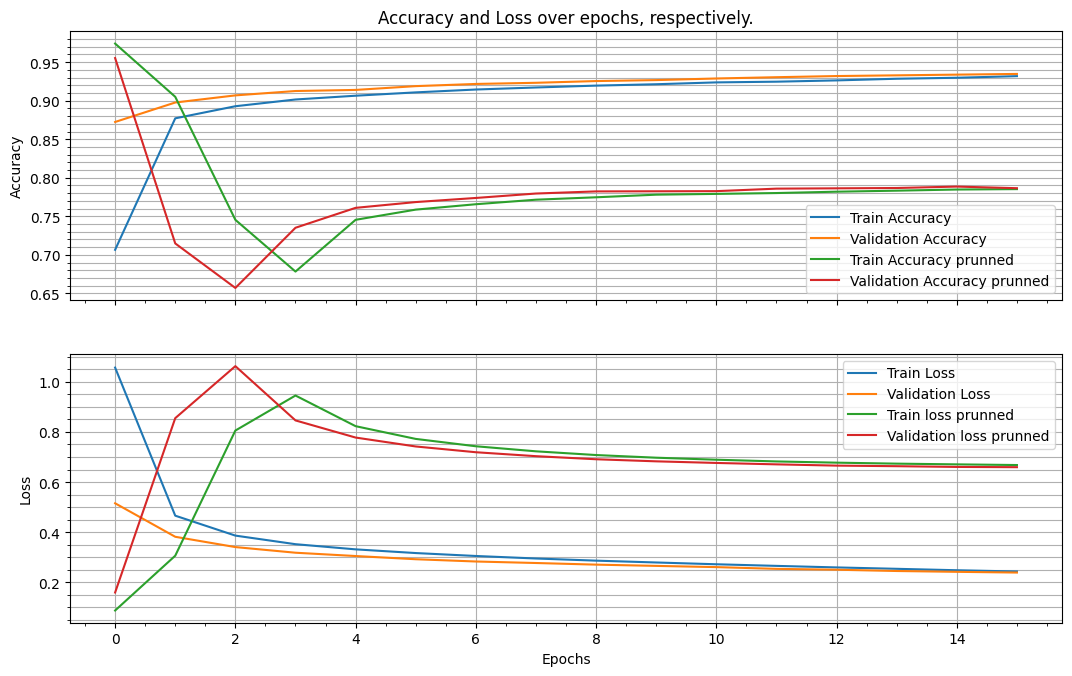

In [47]:
# Plot accuracy and loss over epochs
ax1 = plt.subplot(211)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.plot(historyP.history['accuracy'], label='Train Accuracy prunned')
ax1.plot(historyP.history['val_accuracy'], label='Validation Accuracy prunned')
ax1.minorticks_on()
ax1.tick_params('x', labelbottom=False)
ax1.grid(visible=True, which='both', axis='y')
ax1.grid(visible=True, which='Major', axis='x')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Loss over epochs, respectively.')
ax1.legend()

ax2 = plt.subplot(212)
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.plot(historyP.history['loss'], label='Train loss prunned')
ax2.plot(historyP.history['val_loss'], label='Validation loss prunned')
ax2.minorticks_on()
ax2.grid(visible=True, which='both', axis='y')
ax2.grid(visible=True, which='Major', axis='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)

fname = "../img/compression/prun_accy_n_loss__i" + str(iter)
fname += "__n_layers-1"
fname += "__sparse-" + str(final_sparsity)
plt.savefig(fname + ".png", bbox_inches='tight')

plt.show()

In [25]:
modelP_stripped = strip_pruning(modelP)

modelP_stripped.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_35 (Dense)            (None, 192)               150720    
                                                                 
 dense_36 (Dense)            (None, 128)               24704     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dropout_11 (Dropout)        (None, 128)              

### 📝 Cambio de sparsity

Al aumentar el sparsity, luego del segundo entrenamiento con prunning, se obtiene cada vez menos accuracy y mayor loss, de todas formas en general se suele mejorar el desempeño de la red.

Prunning no estaba teniendo un gran impacto en la red con 220k parametros, al sospechar que era debido a que es innecesariamente grande, se redujo a una red mas pequeña, con una sola capa oculta de 20 neuronas, con 15k parámetros. Al subir el sparsity a 90%, se observa como la red pierde accuracy al intentar eliminar conexiones entre neuronas en las primeras iteraciones:

![img_sparsity](../img/compression/prun_accy_n_loss__i5__n_layers-1__sparse-0.9.png)

## Quantization

### QAT: Quantization-aware training

El modelo se re-define haciendo uso de **QKeras**, una extensión de Keras diseñada para crear y entrenar modelos de redes neuronales con cuantización. Su principal objetivo es optimizar modelos para hardware con recursos limitados, como FPGAs, microcontroladores y aceleradores embebidos.

- Permite definir pesos y activaciones con diferentes niveles de precisión (por ejemplo, 8 bits, 4 bits, ternario (-1, 0, 1), etc.).

- Al reducir la precisión numérica, disminuye el uso de memoria y el costo computacional.

- Facilita la conversión de modelos cuantizados en implementaciones eficientes para FPGAs, garantizando la compatibilidad con hls4ml.

- Compatible con capas estándar de Keras, pero con soporte adicional para configuraciones de precisión baja.

Una vez redefinido el modelo a entrenear mediante QKeras, se procede al entrenamiento del mismo. 

In [24]:
## Quantization
from qkeras import *

## Estrategia de cuantización

## Definición del número de bits para kernel, bias, y activación.
# 8-bits
kernelQ = "quantized_bits(6,3,alpha=1)"
biasQ = "quantized_bits(6,3,alpha=1)"
activationQ = 'quantized_bits(6,3)'

modelQAT = Sequential(
            [   
                Flatten(input_shape=(28, 28)),
                QDense(100, name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu1'),

                Dropout(0.1),

                QDense(50, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),
                

                QDense(20, name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                
                Dropout(0.1),
                
                QDense(10, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
               
            ],

            name="quantizedModel",
        )

c:\.neuralEnv\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [25]:
modelQAT.summary()

Model: "quantizedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 fc1 (QDense)                (None, 100)               78500     
                                                                 
 relu1 (QActivation)         (None, 100)               0         
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 fc2 (QDense)                (None, 50)                5050      
                                                                 
 relu2 (QActivation)         (None, 50)                0         
                                                                 
 dropout_13 (Dropout)        (None, 50)             

In [26]:
# Entrenamiento

import tensorflow.keras.backend as K

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAT = modelQAT.fit(x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )

Epoch 1/16
750/750 [==============================] - 4s 4ms/step - loss: 1.4160 - accuracy: 0.6847 - val_loss: 0.7131 - val_accuracy: 0.8191
Epoch 2/16
750/750 [==============================] - 2s 3ms/step - loss: 0.8628 - accuracy: 0.7698 - val_loss: 0.6202 - val_accuracy: 0.8354
Epoch 3/16
750/750 [==============================] - 2s 3ms/step - loss: 0.8005 - accuracy: 0.7778 - val_loss: 0.5018 - val_accuracy: 0.8583
Epoch 4/16
750/750 [==============================] - 2s 3ms/step - loss: 0.7154 - accuracy: 0.7975 - val_loss: 0.4982 - val_accuracy: 0.8482
Epoch 5/16
750/750 [==============================] - 3s 4ms/step - loss: 0.6668 - accuracy: 0.8074 - val_loss: 0.4294 - val_accuracy: 0.8751
Epoch 6/16
750/750 [==============================] - 3s 4ms/step - loss: 0.6407 - accuracy: 0.8132 - val_loss: 0.4909 - val_accuracy: 0.8572
Epoch 7/16
750/750 [==============================] - 3s 3ms/step - loss: 0.6468 - accuracy: 0.8131 - val_loss: 0.4409 - val_accuracy: 0.8780
Epoch 

#### Metrics

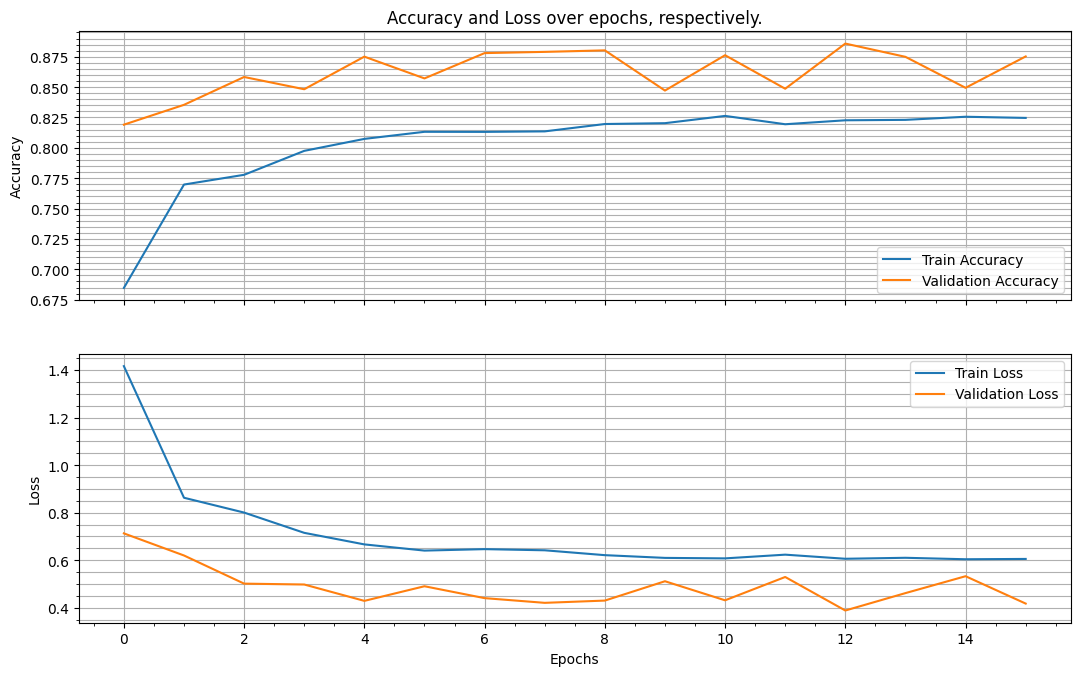

In [27]:
# Plot accuracy and loss over epochs
ax1 = plt.subplot(211)
ax1.plot(historyQAT.history['accuracy'], label='Train Accuracy')
ax1.plot(historyQAT.history['val_accuracy'], label='Validation Accuracy')
ax1.minorticks_on()
ax1.tick_params('x', labelbottom=False)
ax1.grid(visible=True, which='both', axis='y')
ax1.grid(visible=True, which='Major', axis='x')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Loss over epochs, respectively.')
ax1.legend()

ax2 = plt.subplot(212)
ax2.plot(historyQAT.history['loss'], label='Train Loss')
ax2.plot(historyQAT.history['val_loss'], label='Validation Loss')
ax2.minorticks_on()
ax2.grid(visible=True, which='both', axis='y')
ax2.grid(visible=True, which='Major', axis='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)
plt.savefig("../img/Compression_QAT_6bit_3bit_acc_n_loss_iter-" + str(iter) + ".png", bbox_inches='tight')

plt.show()

313/313 [==============================] - 1s 2ms/step


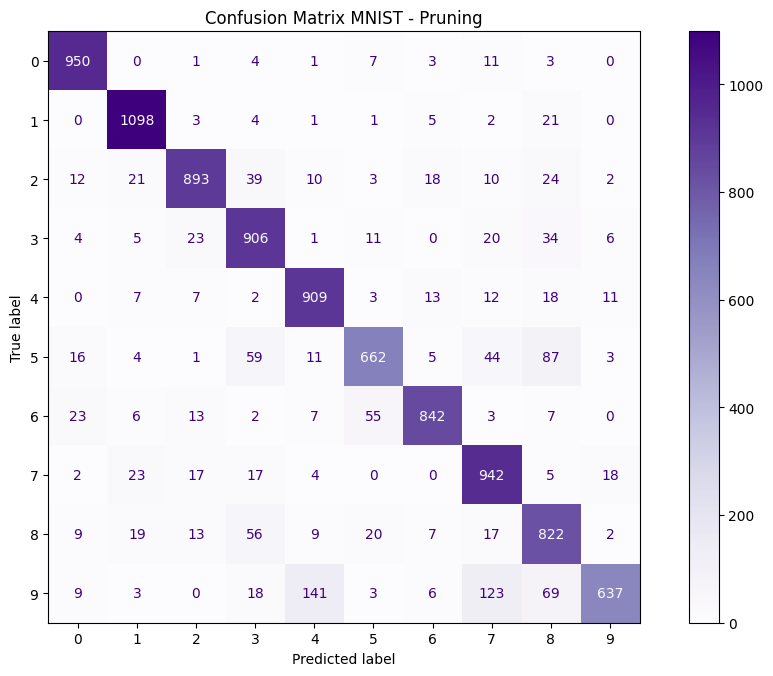

In [28]:
y_pred_probs = modelQAT.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - Pruning')

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)
plt.savefig("../img/Compression_QAT_6bit_3bit_confusion_iter-" + str(iter) + ".png", bbox_inches='tight')

plt.show()

### QAP: Quantization-aware prunning

Quantization-aware pruning (QAP) combina pruning con quantization-aware training. El objetivo es reducir el tamaño del modelo luego de cuantizarlo, para obtener una red más eficiente sin sacrificar precisión.

In [29]:
# defino parametros para prunning
final_sparsity = 0.3

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=3000
                )
            }

In [ ]:
# defino nuevamente la arquitectura cuantizada

## Definición del número de bits para kernel, bias, y activación.
# 8-bits

kernelQ = "quantized_bits(6,3,alpha=0)"
biasQ = "quantized_bits(6,3,alpha=0)"
activationQ = 'quantized_bits(6,3)'

modelQ = Sequential(
            [   
                Flatten(input_shape=(28, 28)),
                QDense(100, name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu1'),

                Dropout(0.1),

                QDense(50, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),
                

                QDense(20, name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                
                Dropout(0.1),
                
                QDense(10, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
               
            ],

            name="quantizedModel",
        )

In [32]:
# Entrenamiento, cuantizado y con prunning
iter += 1

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAP = tfmot.sparsity.keras.prune_low_magnitude(modelQ, **pruning_params)

modelQAP.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAP = modelQAP.fit(x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
                )

Epoch 1/16
750/750 [==============================] - 7s 5ms/step - loss: 1.3766 - accuracy: 0.6876 - val_loss: 0.5686 - val_accuracy: 0.8442
Epoch 2/16
750/750 [==============================] - 3s 4ms/step - loss: 0.8259 - accuracy: 0.7753 - val_loss: 0.5307 - val_accuracy: 0.8532
Epoch 3/16
750/750 [==============================] - 3s 4ms/step - loss: 0.7671 - accuracy: 0.7802 - val_loss: 0.5124 - val_accuracy: 0.8482
Epoch 4/16
750/750 [==============================] - 3s 4ms/step - loss: 0.7107 - accuracy: 0.7941 - val_loss: 0.4832 - val_accuracy: 0.8716
Epoch 5/16
750/750 [==============================] - 3s 4ms/step - loss: 0.6726 - accuracy: 0.8058 - val_loss: 0.4388 - val_accuracy: 0.8741
Epoch 6/16
750/750 [==============================] - 3s 4ms/step - loss: 0.6309 - accuracy: 0.8138 - val_loss: 0.5008 - val_accuracy: 0.8508
Epoch 7/16
750/750 [==============================] - 3s 4ms/step - loss: 0.6300 - accuracy: 0.8135 - val_loss: 0.4253 - val_accuracy: 0.8716
Epoch 

#### Metricas

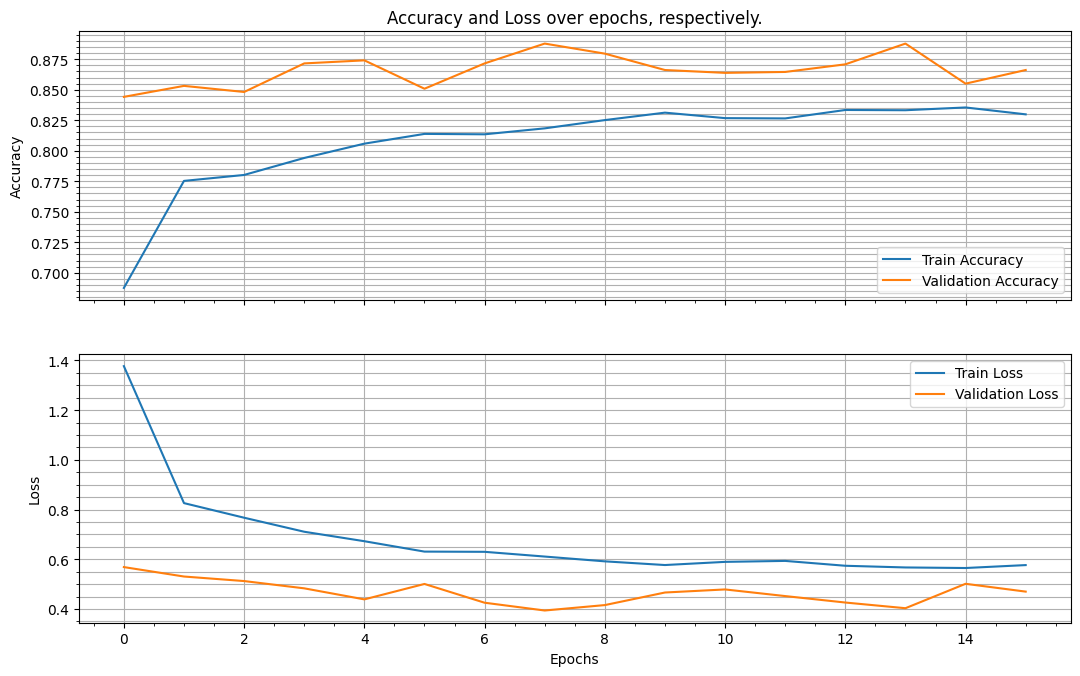

In [33]:
# Plot accuracy and loss over epochs
ax1 = plt.subplot(211)
ax1.plot(historyQAP.history['accuracy'], label='Train Accuracy')
ax1.plot(historyQAP.history['val_accuracy'], label='Validation Accuracy')
ax1.minorticks_on()
ax1.tick_params('x', labelbottom=False)
ax1.grid(visible=True, which='both', axis='y')
ax1.grid(visible=True, which='Major', axis='x')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Loss over epochs, respectively.')
ax1.legend()

ax2 = plt.subplot(212)
ax2.plot(historyQAP.history['loss'], label='Train Loss')
ax2.plot(historyQAP.history['val_loss'], label='Validation Loss')
ax2.minorticks_on()
ax2.grid(visible=True, which='both', axis='y')
ax2.grid(visible=True, which='Major', axis='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)
plt.savefig("../img/Compression_QAP_6bit_3bit_acc_n_loss_iter-" + str(iter) + ".png", bbox_inches='tight')

plt.show()

313/313 [==============================] - 1s 2ms/step


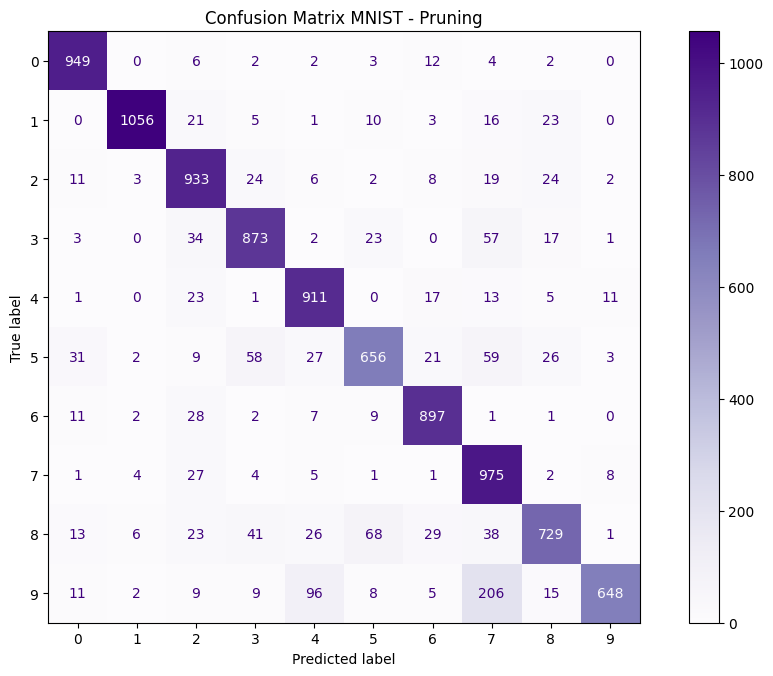

In [34]:
y_pred_probs = modelQAP.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - Pruning')

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)
plt.savefig("../img/Compression_QAP_6bit_3bit_confusion_iter-" + str(iter) + ".png", bbox_inches='tight')

plt.show()

In [35]:
modelQAT.summary()

modelQAP_stripped = strip_pruning(modelQAP)
modelQAP_stripped.summary()

modelQAT.save('../models/mnist_Model_FCNN_QAT_6b_3b.h5')
modelQAP_stripped.save('../models/mnist_Model_FCNN_QAP_6b_3b_prunned.h5')
# model.save('../models/mnist_Model_FCNN.h5')

Model: "quantizedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 fc1 (QDense)                (None, 100)               78500     
                                                                 
 relu1 (QActivation)         (None, 100)               0         
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 fc2 (QDense)                (None, 50)                5050      
                                                                 
 relu2 (QActivation)         (None, 50)                0         
                                                                 
 dropout_13 (Dropout)        (None, 50)             

### 📝 Lab

Al ver la cantidad de parametros de los distintos modelos, todos tienen la misma cantidad...

... el modelo default entrenado pesa 700KB cuando es guardado
... el modelo en el que se efectuó QAT tiene 1MB aproximadamente cuando es guardado
... el modelo en el que se efectuó QAP (o sea quantizacion 8+4bits + prunning) tiene 300KB cuando es guardado

Al volver a generar QAT y QAP con menor cantidad de bits... (6b y 3b), ambos pesan lo mismo cuando se guardan los modelos, tiene sentido ya que la idea es entrenar la red para **prepararla** para cuantizar, pero sin cuantizarla efectivamente; pero sí ocurre que la red entrenada con 6b-3b tiene peor accuracy en general y es mucho mas volátil en entrenamiento, lo que es consecuencia de tener menor precisión para cambiar los pesos sinapticos, el tunning de la red es menos fino.

## Knowledge Distillation

Esta técnica se dedica a transferir conocimiento de una red grande (_teacher_) a una red objetivo más pequeña y más rápida (_distilled_ o _estudiante_) que puede reproducir el comportamiento de la arquitectura maestra y al mismo tiempo ser computacionalmente menos costosa.

### Model definition

In [48]:
# Cargar dataset MNIST (modificado)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0            # Normalización

x_train = x_train.reshape(-1, 28 * 28)                       # Aplanar imágenes
x_test = x_test.reshape(-1, 28 * 28)

y_train = to_categorical(y_train, num_classes=10, dtype=int)
y_test = to_categorical(y_test, num_classes=10, dtype=int)

In [73]:
# definición de modelo teacher
def build_teacher():
    model = keras.Sequential([
        Dense(512, activation="relu", input_shape=(28 * 28,)),
        Dense(256, activation="relu"),
        Dense(10,  activation="softmax")  
    ])
    return model

# definición de modelo student
def build_student():
    model = keras.Sequential([
        Dense(3, activation="relu", input_shape=(28 * 28,)),  
        Dense(3, activation="relu"),
        Dense(3, activation="relu"),
        Dense(3, activation="relu"),
        Dense(10, activation="softmax")  # Softmax en la salida
    ])
    return model

### Distillation process

In [74]:
# Construyo modelos
teacher = build_teacher()
student = build_student()

teacher.summary()
student.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 512)               401920    
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dense_29 (Dense)            (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 3)                 2355      
                                                                 
 dense_31 (Dense)        

In [75]:
# Compilo y entreno teacher
teacher.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
historyTeacher = teacher.fit(x_train, y_train, epochs=16, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/16
469/469 [==============================] - 5s 8ms/step - loss: 0.2299 - accuracy: 0.9325 - val_loss: 0.1117 - val_accuracy: 0.9655
Epoch 2/16
469/469 [==============================] - 3s 7ms/step - loss: 0.0835 - accuracy: 0.9746 - val_loss: 0.0815 - val_accuracy: 0.9750
Epoch 3/16
469/469 [==============================] - 4s 8ms/step - loss: 0.0530 - accuracy: 0.9836 - val_loss: 0.0773 - val_accuracy: 0.9768
Epoch 4/16
469/469 [==============================] - 4s 8ms/step - loss: 0.0373 - accuracy: 0.9880 - val_loss: 0.0716 - val_accuracy: 0.9778
Epoch 5/16
469/469 [==============================] - 4s 8ms/step - loss: 0.0281 - accuracy: 0.9904 - val_loss: 0.0667 - val_accuracy: 0.9800
Epoch 6/16
469/469 [==============================] - 4s 8ms/step - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.0762 - val_accuracy: 0.9789
Epoch 7/16
469/469 [==============================] - 4s 8ms/step - loss: 0.0189 - accuracy: 0.9936 - val_loss: 0.0691 - val_accuracy: 0.9814
Epoch 

In [76]:
# Armo al distiller

train_labels = np.argmax(y_train, axis=1)

distilledMLP = Distiller(student=student, teacher=teacher)

distilledMLP.student.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 3)                 2355      
                                                                 
 dense_31 (Dense)            (None, 3)                 12        
                                                                 
 dense_32 (Dense)            (None, 3)                 12        
                                                                 
 dense_33 (Dense)            (None, 3)                 12        
                                                                 
 dense_34 (Dense)            (None, 10)                40        
                                                                 
Total params: 2,431
Trainable params: 2,431
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Proceso de destilación del conocimiento 
# (entrenamiento de student partiendo del teacher)

adam = Adam(0.0001)

distilledMLP.compile(
        optimizer=adam,
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1,
        temperature=10,
    )

historyDistilled = distilledMLP.fit(x_train, train_labels, validation_split=0.2, batch_size = 64, epochs= 32)

Epoch 1/32


c:\.neuralEnv\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 [==============================] - 3s 4ms/step - sparse_categorical_accuracy: 0.1296 - student_loss: 2.2705 - distillation_loss: 4.6961e-04 - val_sparse_categorical_accuracy: 0.1900 - val_student_loss: 2.2204
Epoch 2/32
750/750 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.1995 - student_loss: 2.1534 - distillation_loss: 4.5886e-04 - val_sparse_categorical_accuracy: 0.1994 - val_student_loss: 2.1096
Epoch 3/32
750/750 [==============================] - 3s 4ms/step - sparse_categorical_accuracy: 0.2054 - student_loss: 2.0722 - distillation_loss: 4.5177e-04 - val_sparse_categorical_accuracy: 0.2020 - val_student_loss: 2.0364
Epoch 4/32
750/750 [==============================] - 3s 3ms/step - sparse_categorical_accuracy: 0.2082 - student_loss: 2.0250 - distillation_loss: 4.4738e-04 - val_sparse_categorical_accuracy: 0.2058 - val_student_loss: 1.9894
Epoch 5/32
750/750 [==============================] - 2s 3ms/step - sparse_categorical_accuracy: 0.

### Metricas

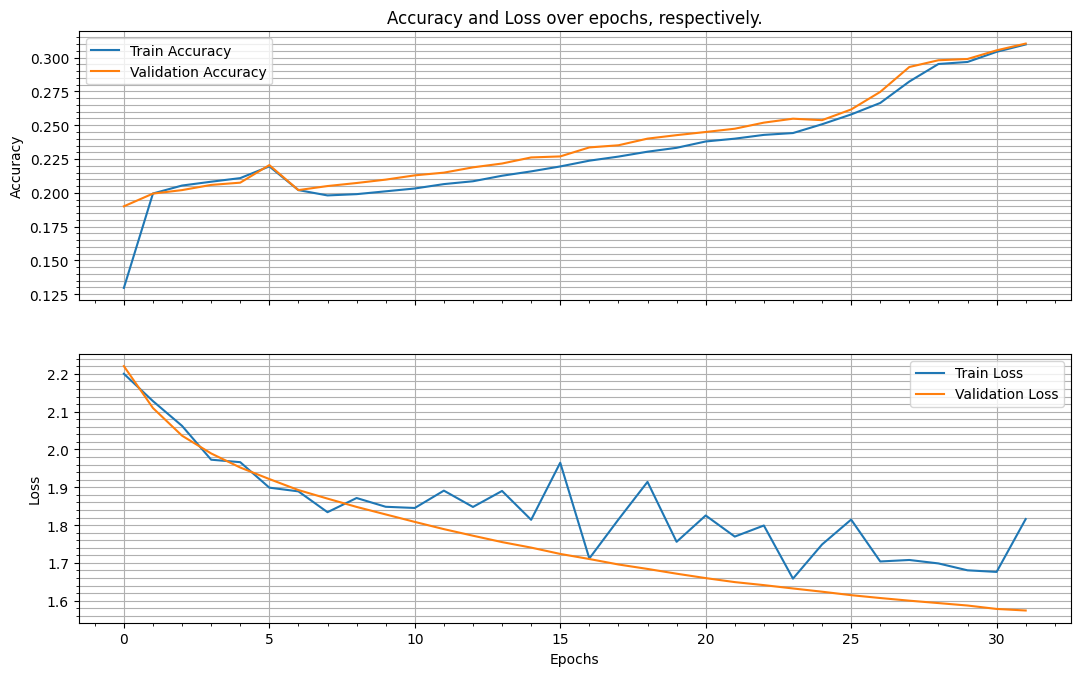

In [78]:
# Plot accuracy and loss over epochs
ax1 = plt.subplot(211)
ax1.plot(historyDistilled.history['sparse_categorical_accuracy'], label='Train Accuracy')
ax1.plot(historyDistilled.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax1.minorticks_on()
ax1.tick_params('x', labelbottom=False)
ax1.grid(visible=True, which='both', axis='y')
ax1.grid(visible=True, which='Major', axis='x')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Loss over epochs, respectively.')
ax1.legend()

ax2 = plt.subplot(212)
ax2.plot(historyDistilled.history['student_loss'], label='Train Loss')
ax2.plot(historyDistilled.history['val_student_loss'], label='Validation Loss')
ax2.minorticks_on()
ax2.grid(visible=True, which='both', axis='y')
ax2.grid(visible=True, which='Major', axis='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)

fname = "../img/Compression_KD_acc_n_loss"
fname += "__iter-" + str(iter) 
fname += "__st_5layers_784-3-3-3-3-10"
plt.savefig(fname + ".png", bbox_inches='tight')

plt.show()

313/313 [==============================] - 1s 2ms/step


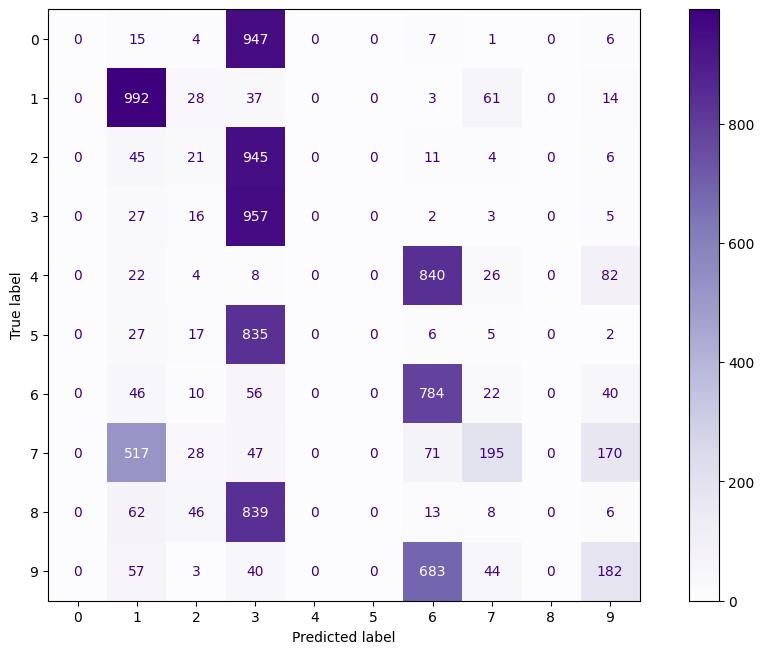

In [79]:
y_pred_probs = distilledMLP.student.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)

fname = "../img/Compression_KD_confusion"
fname += "_iter-" + str(iter) 
fname += "__st_5layers_784-3-3-3-3-10"
plt.savefig(fname + ".png", bbox_inches='tight')

plt.show()

In [ ]:
# guardamos el modelo de student
distilledMLP.student.save("models/mnistKD_iter-" + str(iter) + ".h5")

## 📝 Ejercicios

- Variar la arquitectura del estudiante y analizar el rendimiento del modelo entrenado mediante las métricas correspondientes. Considerar los siguientes escenarios:
    
    - Disminuir el numero de capas.

    - Variar la cantidad de neuronas en cada capa. 

    - Incrementar la cantidad de capas y disminuir la cantidad de neuronas en cada una de las capas. 

    > Con mayor cantidad de capas y menor cantidad de neuronas, el modelo estudiante no es bueno, llega a un accuracy de 60%. Con pocas capas pero mas neuronas (768-5-7-10) el desempeño es excelente para la reducción de parametros que se plantea (de 536k parametros a 2.4k parametros, y un accuracy de 83%).

#### 784 - 5 - 10
![img_KD_2lay_5-10](../img/compression/Compression_KD_acc_n_loss_iter-5__st_2layers_784-5-10.png)

#### 784 - 3 - 3 - 10
![img_KD_2lay_5-10](../img/compression/Compression_KD_acc_n_loss__iter-5__st_3layers_784-3-3-10.png)

#### 784 - 3 - 3 - 3 - 3 - 10
![img_KD_2lay_5-10](../img/compression/Compression_KD_acc_n_loss__iter-5__st_5layers_784-3-3-3-3-10.png)

- Repetir los procesos de compresión para MNIST fashion y CIFAR-10 datasets. 

- ¿Qué conclusiones puede obtener? 

    > Las tecnicas de KD por lo gral son más efectivas en perceptrones (una inferencia que también Hinton explicó en una de sus clases), y lógicamente cuando el maestro tiene un muy buen accuracy. 

- 🎯 Para continuar con el próximo laboratorio: 

    -  **Para MNIST dataset, definir un clasificador binario: que discrimine solamente entre 6 y 9, o entre 7 y 5. Aplicar Quantization-Aware Pruning como método de entrenamiento y compresión.** 

    - **Para el mismo escenario, emplee QAT combinado con Knowledge Distillation**.


## Fashion MNIST & CIFAR-10

In [83]:
modelFashionMNIST = load_model('../models/basicML/mnistModel_FC_iter-5.h5')
modelCIFAR10 = load_model('../models/cifar10Model_CNN_iter-3.h5')

In [ ]:
modelFashionMNIST.summary()
modelCIFAR10.summary()

In [85]:
from keras.datasets import fashion_mnist, cifar10

# Fashion MNIST
(x_train_FashionMNIST, y_train_FashionMNIST), (x_test_FashionMNIST, y_test_FashionMNIST) = fashion_mnist.load_data()
x_train_norm_FashionMNIST, x_test_norm_FashionMNIST = x_train_FashionMNIST / 255.0, x_test_FashionMNIST / 255.0

# Carga del dataset CIFAR-10
(x_train_CIFAR10, y_train_CIFAR10), (x_test_CIFAR10, y_test_CIFAR10) = cifar10.load_data()
x_train_norm_CIFAR10, x_test_norm_CIFAR10 = x_train_CIFAR10 / 255.0, x_test_CIFAR10 / 255.0

In [103]:
# defino nuevos estudiantes
def build_studentFashionMNIST():
    studentFashionMNIST = keras.Sequential([
            Flatten(),
            Dense(7, activation="relu"),
            Dense(10, activation="softmax")  # Softmax en la salida
        ])
    return studentFashionMNIST

def build_studentCIFAR10():
    studentCIFAR10 = keras.Sequential([
            Conv2D(24, (3,3), activation='relu', padding='same', input_shape=(32,32,3)), 
            MaxPooling2D((2,2)),

            Conv2D(48, (3,3), activation='relu', padding='same'),
            MaxPooling2D((2,2)),

            Conv2D(48, (3,3), activation='relu', padding='same'),
            MaxPooling2D((2,2)),

            Flatten(),
            Dense(72, activation='relu'),
            Dense(10, activation='softmax')
        ])
    return studentCIFAR10

studentFashionMNIST = build_studentFashionMNIST()
studentCIFAR10 = build_studentCIFAR10()

# armo los destiladores para cada dataset
distilledFashionMNIST = Distiller(student=studentFashionMNIST, teacher=modelFashionMNIST)
distilledCIFAR10 = Distiller(student=studentCIFAR10, teacher=modelCIFAR10)

# hiperparams para destilación de cada uno
hparams_FashionMNIST = {
    "lr": 1e-4,
    "alpha": 0.1,
    "temp": 10,
    "val_split": 0.2
}

hparams_CIFAR10 = {
    "lr": 1e-4,
    "alpha": 0.1,
    "temp": 10,
    "val_split": 0.2
}

# proceso de destilacción FashionMNIST ------------------------------------------------
distilledFashionMNIST.compile(
        optimizer=Adam(hparams_FashionMNIST["lr"]),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=hparams_FashionMNIST["alpha"], 
        temperature=hparams_FashionMNIST["temp"],
    )

# proceso de destilacción CIFAR10 ------------------------------------------------------
distilledCIFAR10.compile(
        optimizer=Adam(hparams_CIFAR10["lr"]),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=hparams_CIFAR10["alpha"], 
        temperature=hparams_CIFAR10["temp"],
    )

#distilledFashionMNIST.student.summary()
#distilledCIFAR10.student.summary()

In [104]:
iter += 1
## train students ---------
# training FashionMNIST distilled
# historyDistilledFashionMNIST = distilledFashionMNIST.fit(
#     x_train_norm_FashionMNIST, 
#     y_train_FashionMNIST, 
#     validation_split=hparams_FashionMNIST["val_split"], 
#     batch_size = 64, 
#     epochs= 32)

# training CIFAR10 distilled
historyDistilledCIFAR10 = distilledCIFAR10.fit(
    x_train_norm_CIFAR10, 
    y_train_CIFAR10, 
    validation_split=hparams_CIFAR10["val_split"], 
    batch_size = 64, 
    epochs= 32)

Epoch 1/32
625/625 [==============================] - 46s 69ms/step - sparse_categorical_accuracy: 0.3154 - student_loss: 1.9233 - distillation_loss: 2.7060e-04 - val_sparse_categorical_accuracy: 0.4008 - val_student_loss: 2.0252
Epoch 2/32
625/625 [==============================] - 35s 57ms/step - sparse_categorical_accuracy: 0.4294 - student_loss: 1.5898 - distillation_loss: 2.1877e-04 - val_sparse_categorical_accuracy: 0.4569 - val_student_loss: 2.0465
Epoch 3/32
625/625 [==============================] - 35s 55ms/step - sparse_categorical_accuracy: 0.4732 - student_loss: 1.4723 - distillation_loss: 1.9737e-04 - val_sparse_categorical_accuracy: 0.4915 - val_student_loss: 2.0408
Epoch 4/32
625/625 [==============================] - 34s 55ms/step - sparse_categorical_accuracy: 0.5003 - student_loss: 1.3988 - distillation_loss: 1.8338e-04 - val_sparse_categorical_accuracy: 0.5086 - val_student_loss: 1.9292
Epoch 5/32
625/625 [==============================] - 36s 57ms/step - sparse_cat

### Metrics

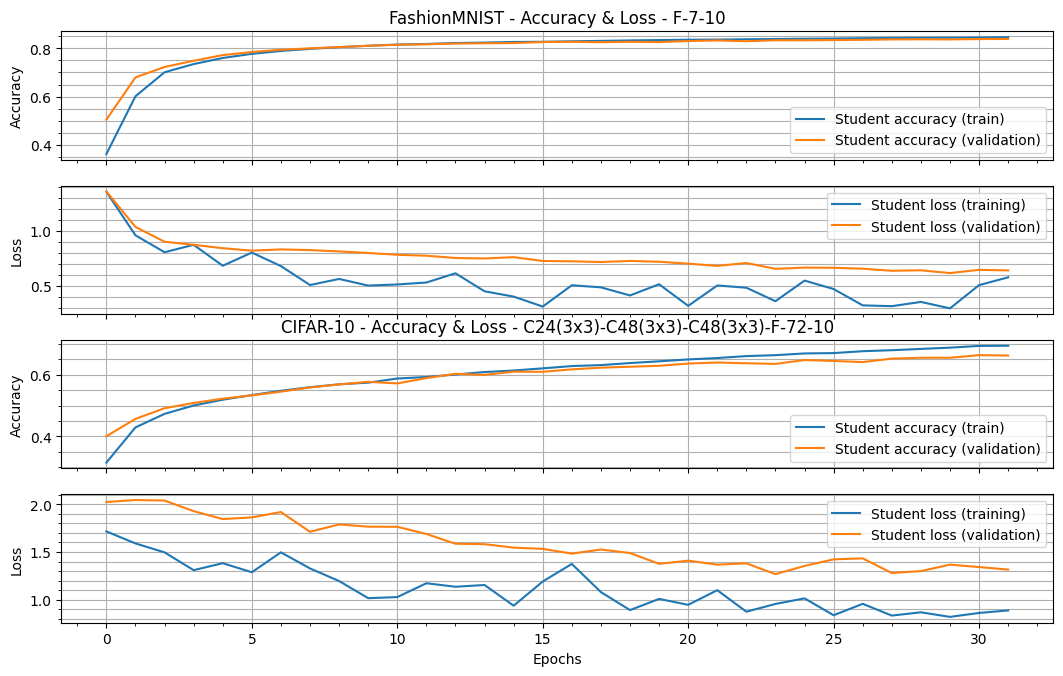

In [105]:
# Plot accuracy and loss over epochs
ax1 = plt.subplot(411)
ax1.plot(historyDistilledFashionMNIST.history['sparse_categorical_accuracy'], label='Student accuracy (train)')
ax1.plot(historyDistilledFashionMNIST.history['val_sparse_categorical_accuracy'], label='Student accuracy (validation)')
ax1.minorticks_on()
ax1.tick_params('x', labelbottom=False)
ax1.grid(visible=True, which='both', axis='y')
ax1.grid(visible=True, which='Major', axis='x')
ax1.set_ylabel('Accuracy')
ax1.set_title('FashionMNIST - Accuracy & Loss - F-7-10')
ax1.legend()

ax2 = plt.subplot(412)
ax2.plot(historyDistilledFashionMNIST.history['student_loss'], label='Student loss (training)')
ax2.plot(historyDistilledFashionMNIST.history['val_student_loss'], label='Student loss (validation)')
ax2.minorticks_on()
ax2.tick_params('x', labelbottom=False)
ax2.grid(visible=True, which='both', axis='y')
ax2.grid(visible=True, which='Major', axis='x')
ax2.set_ylabel('Loss')
ax2.legend()

ax3 = plt.subplot(413)
ax3.plot(historyDistilledCIFAR10.history['sparse_categorical_accuracy'], label='Student accuracy (train)')
ax3.plot(historyDistilledCIFAR10.history['val_sparse_categorical_accuracy'], label='Student accuracy (validation)')
ax3.minorticks_on()
ax3.tick_params('x', labelbottom=False)
ax3.grid(visible=True, which='both', axis='y')
ax3.grid(visible=True, which='Major', axis='x')
ax3.set_ylabel('Accuracy')
ax3.set_title('CIFAR-10 - Accuracy & Loss - C24(3x3)-C48(3x3)-C48(3x3)-F-72-10')
ax3.legend()

ax4 = plt.subplot(414)
ax4.plot(historyDistilledCIFAR10.history['student_loss'], label='Student loss (training)')
ax4.plot(historyDistilledCIFAR10.history['val_student_loss'], label='Student loss (validation)')
ax4.minorticks_on()
ax4.grid(visible=True, which='both', axis='y')
ax4.grid(visible=True, which='Major', axis='x')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')
ax4.legend()

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)

fname = "../img/Compression_KD_acc_n_loss"
fname += f"__i{iter}"
fname += "__st_same_layers"
plt.savefig(fname + ".png", bbox_inches='tight')

plt.show()

In [ ]:
# distilledFashionMNIST.student.save(f"models/KD_FashionMNIST__i{iter}.h5")
distilledCIFAR10.student.save(f"../models/KD_CIFAR10__i{iter}.h5")

## MNIST binario

In [108]:
# Cargar dataset MNIST (modificado)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# seleccionar sólo dos clases (6 y 9, o 5 y 7)
index = np.where((y_train == 6) | (y_train == 9))
(x_train_bin, y_train_bin) = (x_train[index[0]], y_train[index[0]])

index = np.where((y_test == 6) | (y_test == 9))
(x_test_bin, y_test_bin) = (x_test[index[0]], y_test[index[0]])

# Normalización
x_train_bin_norm, x_test_bin_norm = x_train_bin / 255.0, x_test_bin / 255.0

y_train_bin_cat = to_categorical(y_train_bin, num_classes=10, dtype=int)
y_test_bin_cat = to_categorical(y_test_bin, num_classes=10, dtype=int)

### QAP

In [136]:
# defino parametros generales
# para prunning
final_sparsity = 0.995

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=3000
                )
            }

# para cuantización
kernelQ = "quantized_bits(8,4,alpha=1)"
biasQ = "quantized_bits(8,4,alpha=1)"
activationQ = 'quantized_bits(8,4)'

In [137]:
modelQ = Sequential(
            [   
                Flatten(input_shape=(28, 28)),

                QDense(128, name = 'fc1',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                QActivation(activation = activationQ, name = 'relu1'),

                Dropout(0.1),
                QDense(32, name = 'fc2',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                QActivation(activation = activationQ, name = 'relu2'),

                Dropout(0.1),
                QDense(16, name = 'fc3',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                QActivation(activation = activationQ, name = 'relu3'),

                Dropout(0.1),
                QDense(10, name = 'output',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                Activation(activation = 'softmax', name = 'softmax')
            ],

            name="quantizedModel",
        )

In [138]:
# Entrenamiento, cuantizado y con prunning
iter += 1

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAP = tfmot.sparsity.keras.prune_low_magnitude(modelQ, **pruning_params)

modelQAP.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAP = modelQAP.fit(
                x_train_bin_norm, y_train_bin_cat,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
                )

Epoch 1/16
149/149 [==============================] - 5s 8ms/step - loss: 0.5089 - accuracy: 0.9237 - val_loss: 0.0220 - val_accuracy: 0.9962
Epoch 2/16
149/149 [==============================] - 1s 5ms/step - loss: 0.0597 - accuracy: 0.9891 - val_loss: 0.0213 - val_accuracy: 0.9971
Epoch 3/16
149/149 [==============================] - 1s 5ms/step - loss: 0.0539 - accuracy: 0.9915 - val_loss: 0.0100 - val_accuracy: 0.9971
Epoch 4/16
149/149 [==============================] - 1s 5ms/step - loss: 0.0364 - accuracy: 0.9928 - val_loss: 0.0140 - val_accuracy: 0.9979
Epoch 5/16
149/149 [==============================] - 1s 5ms/step - loss: 0.0360 - accuracy: 0.9932 - val_loss: 0.0108 - val_accuracy: 0.9975
Epoch 6/16
149/149 [==============================] - 1s 5ms/step - loss: 0.0265 - accuracy: 0.9940 - val_loss: 0.0041 - val_accuracy: 0.9992
Epoch 7/16
149/149 [==============================] - 1s 5ms/step - loss: 0.0226 - accuracy: 0.9947 - val_loss: 0.0140 - val_accuracy: 0.9971
Epoch 

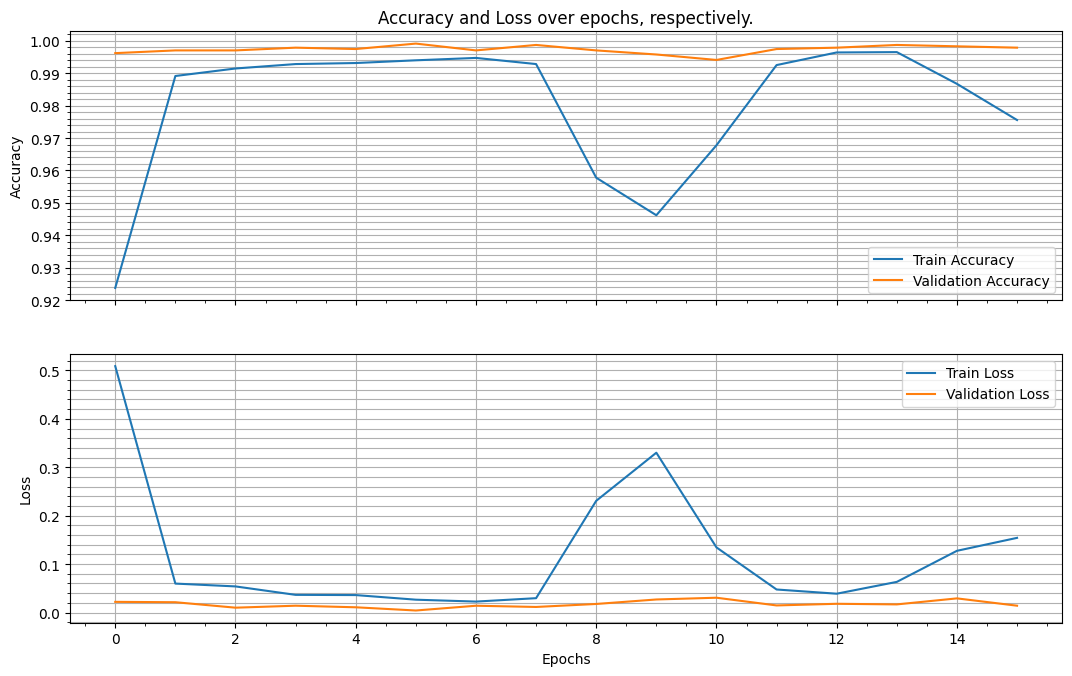

In [139]:
# Plot accuracy and loss over epochs
ax1 = plt.subplot(211)
ax1.plot(historyQAP.history['accuracy'], label='Train Accuracy')
ax1.plot(historyQAP.history['val_accuracy'], label='Validation Accuracy')
ax1.minorticks_on()
ax1.tick_params('x', labelbottom=False)
ax1.grid(visible=True, which='both', axis='y')
ax1.grid(visible=True, which='Major', axis='x')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Loss over epochs, respectively.')
ax1.legend()

ax2 = plt.subplot(212)
ax2.plot(historyQAP.history['loss'], label='Train Loss')
ax2.plot(historyQAP.history['val_loss'], label='Validation Loss')
ax2.minorticks_on()
ax2.grid(visible=True, which='both', axis='y')
ax2.grid(visible=True, which='Major', axis='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)
plt.savefig(f"../img/latest_MNIST_QAP_8B-4B_acc_n_loss_i{iter}.png", bbox_inches='tight')

plt.show()

### QAT + KD

In [129]:
# definición de modelo teacher (debería usar modelQ?)
modelMNIST_teacherQ = Sequential(
            [   
                Flatten(input_shape=(28, 28)),

                QDense(128, name = 'fc1',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                QActivation(activation = activationQ, name = 'relu1'),

                Dropout(0.1),
                QDense(32, name = 'fc2',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                QActivation(activation = activationQ, name = 'relu2'),

                Dropout(0.1),
                QDense(16, name = 'fc3',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                QActivation(activation = activationQ, name = 'relu3'),

                Dropout(0.1),
                QDense(10, name = 'output',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                Activation(activation = 'softmax', name = 'softmax')
            ],

            name="quantizedTeacherModel",
        )

# definicion de modelo student (TODO: usar modelQ_student)
modelMNIST_studentQ = Sequential(
            [   
                Flatten(input_shape=(28, 28)),

                QDense(4, name = 'fc1',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                QActivation(activation = activationQ, name = 'relu1'),

                QDense(2, name = 'fc2',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                QActivation(activation = activationQ, name = 'relu2'),

                QDense(10, name = 'output',
                        kernel_quantizer = kernelQ,
                        bias_quantizer = biasQ,
                        kernel_initializer = 'lecun_uniform'),
                Activation(activation = 'softmax', name = 'softmax')
            ],

            name="quantizedStudentModel",
        )

In [130]:
modelMNIST_teacherQ.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAT = modelMNIST_teacherQ.fit(
                x_train_bin_norm, y_train_bin_cat,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )

distilledMNIST = Distiller(student=modelMNIST_studentQ, teacher=modelMNIST_teacherQ)

hparams_MNIST = {
    "lr": 1e-4,
    "alpha": 0.1,
    "temp": 10,
    "val_split": 0.2
}

distilledMNIST.compile(
        optimizer=Adam(hparams_MNIST["lr"]),
        metrics=[keras.metrics.CategoricalAccuracy()],
        student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=hparams_MNIST["alpha"], 
        temperature=hparams_MNIST["temp"],
    )

historyDistilledMNIST = distilledMNIST.fit(
    x_train_bin_norm, y_train_bin_cat,
    validation_split=hparams_MNIST["val_split"], 
    batch_size = 64, 
    epochs= 32)

Epoch 1/16
149/149 [==============================] - 2s 7ms/step - loss: 0.2614 - accuracy: 0.9658 - val_loss: 0.0179 - val_accuracy: 0.9966
Epoch 2/16
149/149 [==============================] - 1s 4ms/step - loss: 0.0322 - accuracy: 0.9947 - val_loss: 0.0098 - val_accuracy: 0.9983
Epoch 3/16
149/149 [==============================] - 1s 4ms/step - loss: 0.0196 - accuracy: 0.9960 - val_loss: 0.0200 - val_accuracy: 0.9962
Epoch 4/16
149/149 [==============================] - 1s 4ms/step - loss: 0.0218 - accuracy: 0.9952 - val_loss: 0.0119 - val_accuracy: 0.9975
Epoch 5/16
149/149 [==============================] - 1s 4ms/step - loss: 0.0139 - accuracy: 0.9968 - val_loss: 0.0086 - val_accuracy: 0.9979
Epoch 6/16
149/149 [==============================] - 1s 4ms/step - loss: 0.0121 - accuracy: 0.9974 - val_loss: 0.0066 - val_accuracy: 0.9992
Epoch 7/16
149/149 [==============================] - 1s 4ms/step - loss: 0.0102 - accuracy: 0.9976 - val_loss: 0.0056 - val_accuracy: 0.9987
Epoch 

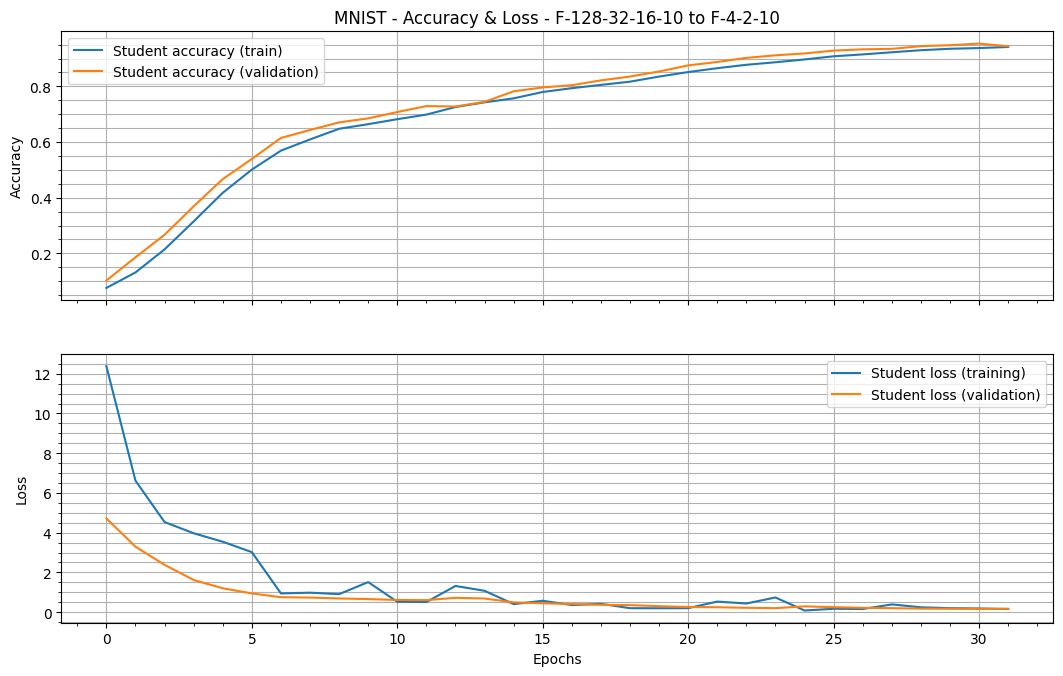

In [131]:
ax1 = plt.subplot(211)
ax1.plot(historyDistilledMNIST.history['categorical_accuracy'], label='Student accuracy (train)')
ax1.plot(historyDistilledMNIST.history['val_categorical_accuracy'], label='Student accuracy (validation)')
ax1.minorticks_on()
ax1.tick_params('x', labelbottom=False)
ax1.grid(visible=True, which='both', axis='y')
ax1.grid(visible=True, which='Major', axis='x')
ax1.set_ylabel('Accuracy')
ax1.set_title('MNIST - Accuracy & Loss - F-128-32-16-10 to F-4-2-10')
ax1.legend()

ax2 = plt.subplot(212)
ax2.plot(historyDistilledMNIST.history['student_loss'], label='Student loss (training)')
ax2.plot(historyDistilledMNIST.history['val_student_loss'], label='Student loss (validation)')
ax2.minorticks_on()
ax2.grid(visible=True, which='both', axis='y')
ax2.grid(visible=True, which='Major', axis='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)

plt.savefig(f"../img/latest_MNIST_QAT-KD_8B-4B_acc_n_loss_i{iter}.png", bbox_inches='tight')

plt.show()

In [ ]:
# save models
distilledMNIST.student.save(f"../models/latest_QAT-KD_MNIST__i{iter}.h5")
modelQAP.save(f"../models/latest_QAP_MNIST__i{iter}.h5")